In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

In [12]:
X_train = joblib.load('../../preprocessed_data/CICIOT/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/CICIOT/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/CICIOT/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/CICIOT/Y_test.joblib')

### CNN training

In [13]:
CNN_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), # keep the maximum each 2 values (divide by 2 the number of values)
    Dropout(0.3), # disable 30% of neurons => reduce overfitting
    Flatten(), # transform the structure from 3D to 2D
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # binary output (0=normal or 1=attack)
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.summary()

history = CNN_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 30, 32)            128       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 15, 32)            0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 15, 32)            0         
                                                                 
 flatten_2 (Flatten)         (None, 480)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                30784     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                      

### LSTM training

In [14]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()


history = LSTM_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21121 (82.50 KB)
Trainable params: 21121 (82.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
11530/11

### AE-LSTM

In [15]:
input_dim = X_train.shape[1]  # n_features

# encoder
inputs = Input(shape=(input_dim, 1))
encoded = LSTM(64, return_sequences=False)(inputs)
encoded = Dense(32, activation='relu')(encoded)

# classifier
x = Dropout(0.3)(encoded)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

AE_LSTM_model = Model(inputs, output)

AE_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
AE_LSTM_model.summary()


history = AE_LSTM_model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test)
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 64)                2112      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 65    

Let's save our models

In [16]:
CNN_model.save("../../models/cnn_ciciot_model.keras")

In [17]:
LSTM_model.save("../../models/lstm_ciciot_model.keras")

In [18]:
AE_LSTM_model.save("../../models/ae-lstm_ciciot_model.keras")

In [19]:
import pickle

In [20]:
file_name_cnn = '../../models/cnn_CICIOT2023.pkl' 
joblib.dump(CNN_model, file_name_cnn) 

file_name_lstm = '../../models/lstm_CICIOT2023.pkl' 
joblib.dump(LSTM_model, file_name_lstm) 

file_name_ae_lstm = '../../models/ae-lstm_CICIOT2023.pkl' 
joblib.dump(AE_LSTM_model, file_name_ae_lstm)

['../../models/ae-lstm_CICIOT2023.pkl']

### CNN metrics

9883/9883 [==============================] - 8s 798us/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    155158
     Attacks       1.00      1.00      1.00    161068

    accuracy                           1.00    316226
   macro avg       1.00      1.00      1.00    316226
weighted avg       1.00      1.00      1.00    316226

Test Loss: 0.0000
Test Accuracy: 1.0000


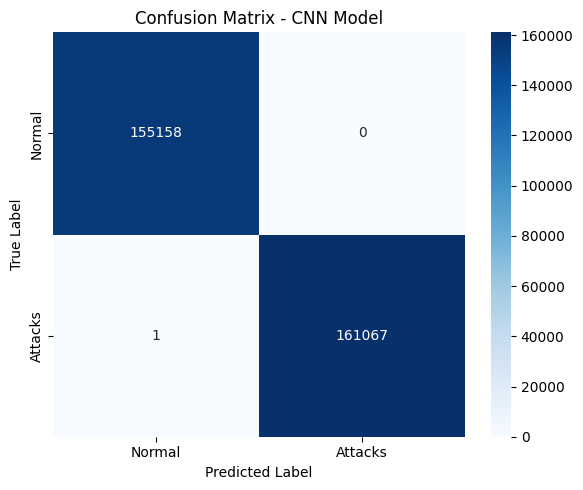

Attacks detected (True Positive) : 161067
Normal traffic detected (True Negative) : 155158
Attacks missed (False Negative) : 1
False alarms (False Positive) : 0


<Figure size 640x480 with 0 Axes>

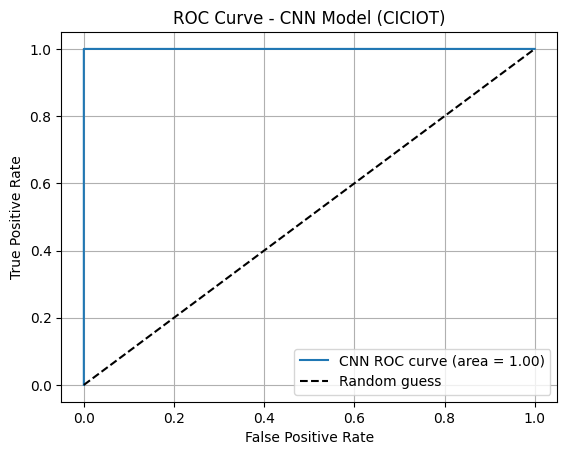

<Figure size 640x480 with 0 Axes>

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.show()
plt.savefig("../../results/CICIOT/CNN_matrix.png", dpi=300, bbox_inches='tight')

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'CNN ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
plt.savefig("../../results/CICIOT/CNN_ROC_curve.png", dpi=300, bbox_inches='tight')

### LSTM metrics

9883/9883 [==============================] - 23s 2ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    155158
     Attacks       1.00      1.00      1.00    161068

    accuracy                           1.00    316226
   macro avg       1.00      1.00      1.00    316226
weighted avg       1.00      1.00      1.00    316226

Test Loss: 0.0000
Test Accuracy: 1.0000


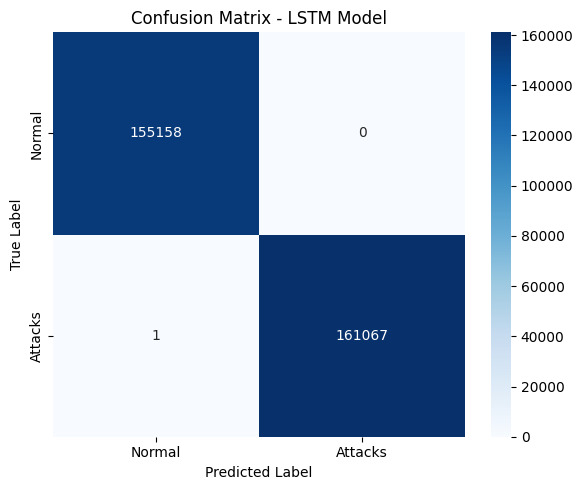

Attacks detected (True Positive) : 161067
Normal traffic detected (True Negative) : 155158
Attacks missed (False Negative) : 1
False alarms (False Positive) : 0


<Figure size 640x480 with 0 Axes>

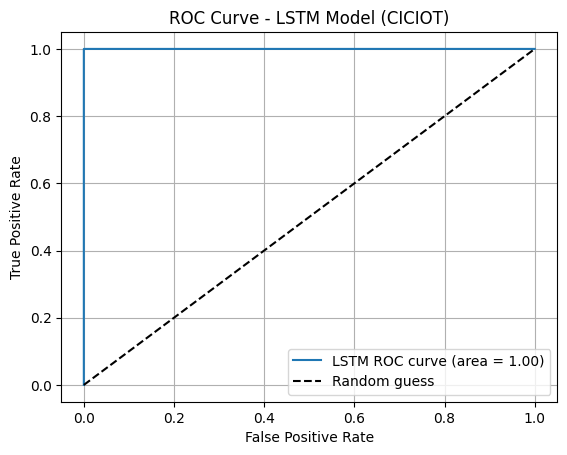

<Figure size 640x480 with 0 Axes>

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Model')
plt.tight_layout()
plt.show()
plt.savefig("../../results/CICIOT/LSTM_matrix.png", dpi=300, bbox_inches='tight')

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
plt.savefig("../../results/CICIOT/LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')


### AE-LSTM metrics

9883/9883 [==============================] - 27s 3ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    155158
     Attacks       1.00      1.00      1.00    161068

    accuracy                           1.00    316226
   macro avg       1.00      1.00      1.00    316226
weighted avg       1.00      1.00      1.00    316226

Test Loss: 0.0000
Test Accuracy: 1.0000


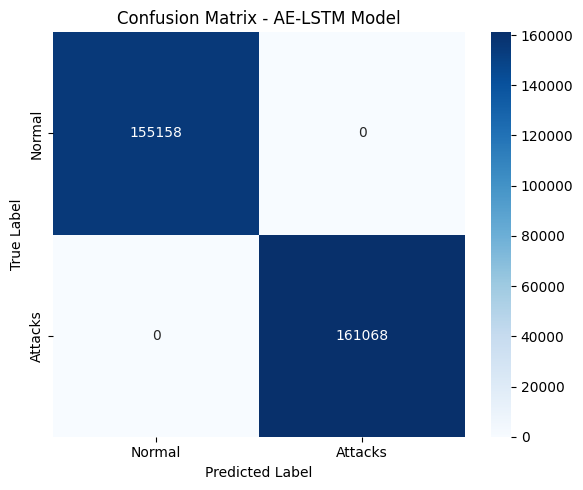

Attacks detected (True Positive) : 161068
Normal traffic detected (True Negative) : 155158
Attacks missed (False Negative) : 0
False alarms (False Positive) : 0


<Figure size 640x480 with 0 Axes>

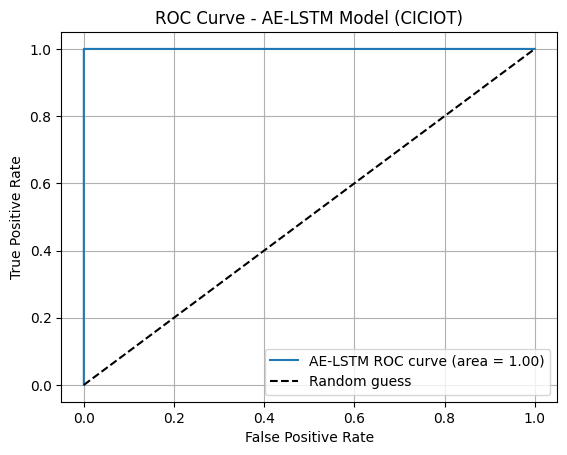

<Figure size 640x480 with 0 Axes>

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = AE_LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AE-LSTM Model')
plt.tight_layout()
plt.show()
plt.savefig("../../results/CICIOT/AE-LSTM_matrix.png", dpi=300, bbox_inches='tight')

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AE-LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AE-LSTM Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
plt.savefig("../../results/CICIOT/AE-LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')